In [24]:
import numpy as np
from lattice_class import *
import scipy.linalg
import matplotlib.pyplot as plt

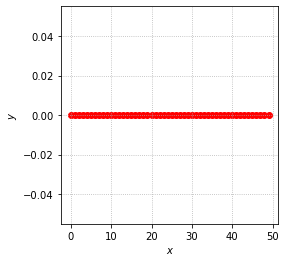

In [25]:
N = 50
lattice = ChainLatticeAlt(N, "open")
lattice.plot()
num_sites = lattice.get_num_sites()

lattice_sites = lattice.get_sites()
lattice_edges = lattice.get_edges()
reciprocal_lattice_sites = lattice.get_reciprocal_sites()

Energies =  [-1.49841295e+00 -1.49841295e+00 -1.49365862e+00 -1.49365862e+00
 -1.48575741e+00 -1.48575741e+00 -1.47474331e+00 -1.47474331e+00
 -1.46066380e+00 -1.46066380e+00 -1.44357981e+00 -1.44357981e+00
 -1.42356559e+00 -1.42356559e+00 -1.40070859e+00 -1.40070859e+00
 -1.37510942e+00 -1.37510942e+00 -1.34688164e+00 -1.34688164e+00
 -1.31615173e+00 -1.31615173e+00 -1.28305900e+00 -1.28305900e+00
 -1.24775554e+00 -1.24775554e+00 -1.21040627e+00 -1.21040627e+00
 -1.17118907e+00 -1.17118907e+00 -1.13029496e+00 -1.13029496e+00
 -1.08792857e+00 -1.08792857e+00 -1.04430866e+00 -1.04430866e+00
 -9.99669050e-01 -9.99669050e-01 -9.54259736e-01 -9.54259736e-01
 -9.08348551e-01 -9.08348551e-01 -8.62223251e-01 -8.62223251e-01
 -8.16194225e-01 -8.16194225e-01 -7.70597886e-01 -7.70597886e-01
 -7.25800779e-01 -7.25800779e-01 -6.82204369e-01 -6.82204369e-01
 -6.40250424e-01 -6.40250424e-01 -6.00427150e-01 -6.00427150e-01
 -5.63278680e-01 -5.63278680e-01 -5.29439397e-01 -5.29439397e-01
 -5.00320681e

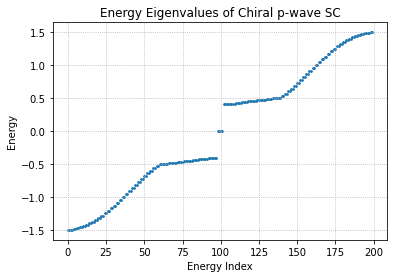

In [26]:
mu = -0.5
delta = complex(0.5, 0.0)

H_k = lambda k: np.array(
    [
        [-(np.cos(k[0]) + np.cos(k[1])) - mu, 0.0],
        [0.0, -(np.cos(k[0]) + np.cos(k[1])) - mu],
    ],
    dtype=complex,
)
gap_fct = lambda k: np.array(
    [
        [0.0, delta * complex(np.sin(k[0]), np.sin(k[1]))],
        [delta.conjugate() * complex(np.sin(k[0]), -np.sin(k[1])), 0.0],
    ],
    dtype=complex,
)
H_BdG = lambda k: np.block(
    [[H_k(k), gap_fct(k)], [gap_fct(k).conj().T, -H_k(-k).conj()]]
)
dim_H_BdG = 4


def get_H_tilde(direction, axis=0):
    H_tilde = np.zeros(shape=(dim_H_BdG, dim_H_BdG), dtype=complex)
    for k in reciprocal_lattice_sites:
        H_tilde += (
            1.0
            / num_sites
            * H_BdG(np.array(k) / N)
            * np.exp(direction * complex(0.0, 1.0) * k[axis] / N)
        )
    return H_tilde


H_direct_lattice = np.zeros(
    shape=(num_sites * dim_H_BdG, num_sites * dim_H_BdG), dtype=complex
)
block_indices = [
    slice(block_idx * dim_H_BdG, (block_idx + 1) * dim_H_BdG)
    for block_idx in range(lattice.get_num_sites())
]

for (site_idx, site) in enumerate(lattice.get_sites()):
    H_direct_lattice[block_indices[site_idx], block_indices[site_idx]] = get_H_tilde(0)

    for neighbour_idx in lattice_edges[site_idx]:
        axis = -1
        if (neighbour_idx // N) != (site_idx // N):
            axis = 1
        elif (neighbour_idx // N) == (site_idx // N):
            axis = 0
        else:
            print(
                "something went terribly wrong while constructing the direct lattice hamiltonian"
            )
        assert axis == 0 or axis == 1, "axis assertion failed"

        direction = 0
        if site_idx < neighbour_idx:
            direction = (-1) ** axis
        elif site_idx > neighbour_idx:
            direction = -1 * (-1) ** axis
        else:
            print(
                "something went terribly wrong while constructing the direct lattice hamiltonian"
            )
        assert direction == 1 or direction == -1, "direction assertion failed"

        # print("Site {} has neighbour {} along axis {} in direction {}".format(site_idx, neighbour_idx, axis, direction))

        H_direct_lattice[
            block_indices[site_idx], block_indices[neighbour_idx]
        ] = get_H_tilde(direction, axis)

energies, states = scipy.linalg.eigh(H_direct_lattice)
print("Energies = ", energies)
print("Lowest found energy: ", np.min(np.abs(energies)))
gs_idx = np.argmin(np.abs(energies))
print("Index of lowest absolute energy: ", gs_idx)

plt.xlabel("Energy Index")
plt.ylabel("Energy")
plt.grid(linestyle=":")
plt.title("Energy Eigenvalues of Chiral p-wave SC")
plt.scatter(range(len(energies)), energies, s=3)

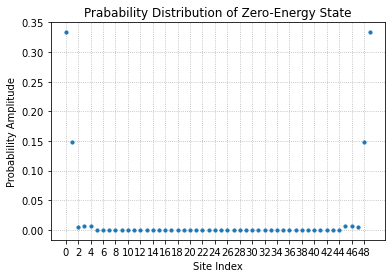

In [27]:
gs_wave_function = states[:, gs_idx]
gs_probabilities_nambu = np.square(np.abs(gs_wave_function))
gs_probabilities = np.zeros(shape=(num_sites, 1))

for site_idx in range(num_sites):
    gs_probabilities[site_idx] = np.sum(gs_probabilities_nambu[block_indices[site_idx]])

plt.xlabel("Site Index")
plt.xticks(range(0, num_sites, num_sites // min(num_sites, 20)))
plt.ylabel("Probablility Amplitude")
plt.title("Prabability Distribution of Zero-Energy State")
plt.grid(linestyle=":", zorder=-10)
plt.scatter(range(num_sites), gs_probabilities, s=10, zorder=10)

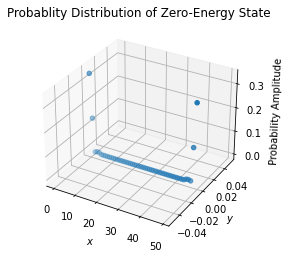

In [28]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
x_values = [k[0] for k in lattice_sites]
y_values = [k[1] for k in lattice_sites]

plt.grid(linestyle=":")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel("Probability Amplitude")
ax.set_title("Probablity Distribution of Zero-Energy State")
ax.scatter(x_values, y_values, gs_probabilities)